In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import os
import csv

In [5]:
from keras.utils import to_categorical

X_train = []
Y_train = []
img_size = 32
channels = 3
num_classes = 43

with open('/content/drive/MyDrive/images_color.csv', 'r') as f:
  reader = csv.reader(f)
  for row in reader:
    if row[0]!='':
      label = row[0]
      image = np.array([int(a) for a in row[1:]], dtype='uint8')
      image = image.reshape((img_size, img_size, channels))
      X_train.append(image)
      Y_train.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Y_train = to_categorical(Y_train)
print(X_train.shape)
print(Y_train.shape)

(39209, 32, 32, 3)
(39209, 43)


In [6]:
X_test = []
Y_test = []

with open('/content/drive/MyDrive/test_set_in_csv.csv', 'r') as f:
  reader = csv.reader(f)
  header = next(reader)
  for row in reader:
    if len(row)!=0:
      label = row[0]
      image = np.array([int(a) for a in row[1:]], dtype='uint8')
      image = image.reshape((32, 32, 3))
      X_test.append(image)
      Y_test.append(label)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_test = to_categorical(Y_test)
print(X_test.shape)
print(Y_test.shape)

(12629, 32, 32, 3)
(12629, 43)


In [7]:
import keras
from keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model, Sequential

model = Sequential() 
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(img_size, img_size, channels)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.3))
    
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.4))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
    
model.add(Dense(num_classes, activation='softmax'))

In [8]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [9]:
batch_size = 16
epochs = 50

history = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, Y_test),
            shuffle=True,)

Epoch 1/50
2451/2451 [==============================] - 55s 10ms/step - loss: 1.3090 - accuracy: 0.6777 - val_loss: 0.1584 - val_accuracy: 0.9507
Epoch 2/50
2451/2451 [==============================] - 25s 10ms/step - loss: 0.1471 - accuracy: 0.9548 - val_loss: 0.5893 - val_accuracy: 0.8327
Epoch 3/50
2451/2451 [==============================] - 25s 10ms/step - loss: 0.1242 - accuracy: 0.9620 - val_loss: 0.1114 - val_accuracy: 0.9717
Epoch 4/50
2451/2451 [==============================] - 25s 10ms/step - loss: 0.0791 - accuracy: 0.9756 - val_loss: 0.1120 - val_accuracy: 0.9684
Epoch 5/50
2451/2451 [==============================] - 25s 10ms/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 0.0801 - val_accuracy: 0.9774
Epoch 6/50
2451/2451 [==============================] - 25s 10ms/step - loss: 0.0587 - accuracy: 0.9823 - val_loss: 0.1348 - val_accuracy: 0.9657
Epoch 7/50
2451/2451 [==============================] - 25s 10ms/step - loss: 0.0518 - accuracy: 0.9841 - val_loss: 0.0902 -

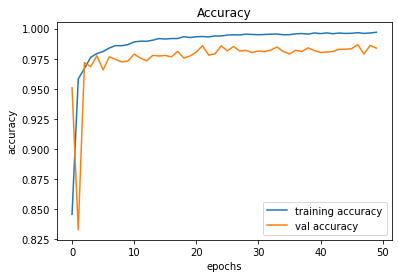

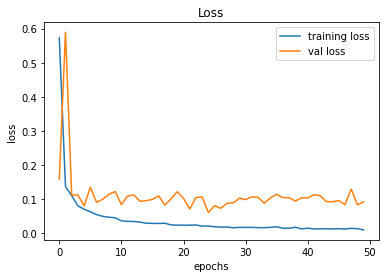

In [10]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
prediction = model.evaluate(X_test, Y_test)
print('loss : {}'.format(prediction[0]))
print('accuracy: {}'.format(prediction[1]))

395/395 [==============================] - 2s 5ms/step - loss: 0.0918 - accuracy: 0.9838
loss : 0.09179773181676865
accuracy: 0.9837675094604492


In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)

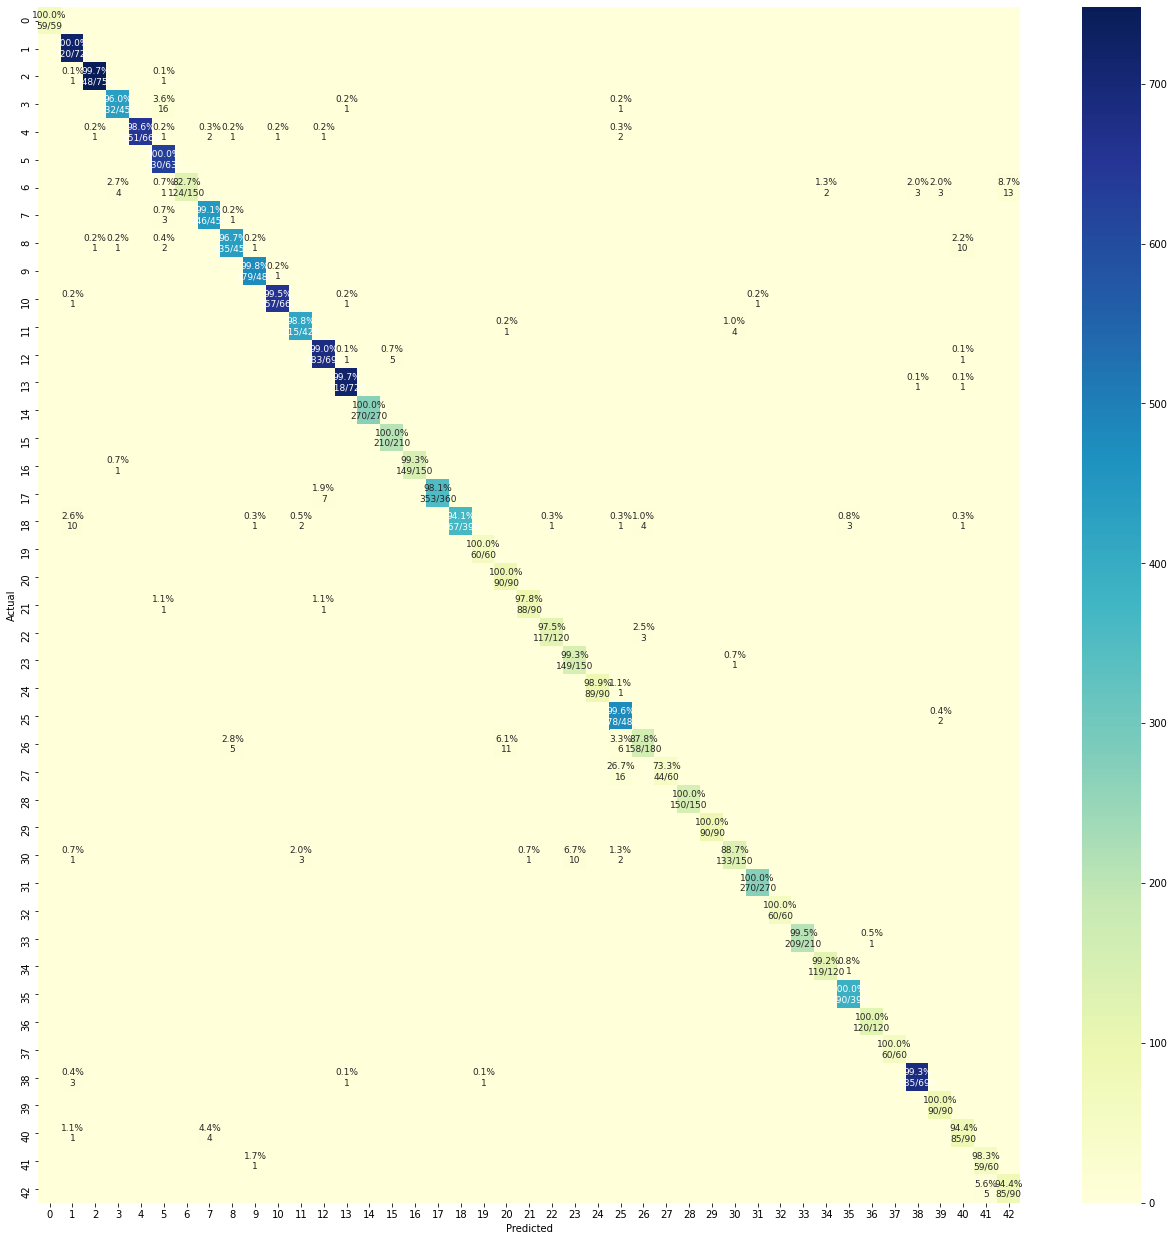

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(Y_test, y_pred, figsize=(22,22)):
    cm = confusion_matrix(Y_test, y_pred, labels=np.unique(Y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                
            elif c == 0:
                annot[i, j] = ''
                
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
                
    cm = pd.DataFrame(cm, columns = np.unique(Y_test), index = np.unique(y_pred))
    
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"size": 9})
    
plot_cm(Y_test, y_pred)

In [18]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       0.98      1.00      0.99       720
           2       1.00      1.00      1.00       750
           3       0.99      0.96      0.97       450
           4       1.00      0.99      0.99       660
           5       0.96      1.00      0.98       630
           6       1.00      0.83      0.91       150
           7       0.99      0.99      0.99       450
           8       0.98      0.97      0.98       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.99      0.99       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      0.99      1.00       150
          17       1.00    